# <font color=#2e86c1> Calculating NMR Parameters from MD Simulations 2: Calculating Relaxation </font> 

In the previous section, we learned how to derive order parameters and correlation functions from an MD trajectory. Now, the question is, how do we acquire NMR rate constants from the correlation functions. To begin, we give the formulas for a few rate constants, where relaxation results from a single strong dipole coupling and chemical shift anisotropy (for backbone H–N motion that we will analyze here, these are sufficient terms to reproduce the relaxation).

$$
\begin{eqnarray}
R_1^I&=& \left(\frac{\delta^{IS}}{4}\right)^2(J(\omega_I-\omega_S)+3J(\omega_I)+6J(\omega_I+\omega_S))+\frac13(\omega_I\Delta\sigma_I)^2J(\omega_I)\\
R_2^I&=& \frac12R_1^I+\left(\frac{\delta^{IS}}{4}\right)^2(J(\omega_S)+2J(0)+\frac29(\omega_I\Delta\sigma_I)^2J(0)\\
\Gamma_{IS}&=& \left(\frac{\delta^{IS}}{4}\right)^2(-J(\omega_I-\omega_S)+6J(\omega_I+\omega_S))
\end{eqnarray}
$$

These yield the orientationally averaged rate constants, which is relevant in solids where the relaxation is multiexponential (meaning we should be careful to extract the average rate when fitting to experiment and comparing). The critical terms are the sizes of the interactions ($\delta^{IS}$, $\omega_I\Delta\sigma_I$), and the frequencies at which the spectral densities are sampled (0, $\omega_S$, $\omega_I$, $\omega_I\pm\omega_S$).

The spectral density itself is given by the real part of the Fourier transform of the correlation function, that is:

$$
J(\omega)=2\int\limits_0^\infty{C(t)\cos(\omega t)dt}
$$

We usually assume that $C(t)$ is symmetric in time, so that we integrate from 0 instead of $-\infty$, and multiply by 2. A factor of 1/5 needs to appear in the correlation function to account for the isotropic average over starting orientations. This factor is sometimes incorporated into the correlation function for overall tumbling, i.e. for isotropic tumbling the correlation function is $C(t)=\frac15\exp(-t/\tau_M)$, and then the total correlation function is $C(t)=\frac15\exp(-t/\tau_M)C_{int.}(t)$. However, if no overall tumbling is present because we are working in solids, then the factor of $1/5$ needs to nonetheless be included. Note that what we have calculated in the previous section is $C_{int.}(t)$

We could, in principle, Fourier transform the correlation functions from the previous section directly (after subtracting the order parameter away). Instead, what we usually do is assume the correlation function is a sum of exponentially decaying functions, and fit the corresponding parameters. 

$$
C_{int}(t)=S^2+\sum\limits_i{A_i\exp(-t/\tau_i)}
$$

Here, $S^2=1-\sum_i{A_i}$.

In the case that we have only internal motion (no tumbling), the spectral density may be written as follows, noting that the Fourier transform of an exponential is a Lorentzian function

$$
J(\omega)=2\sum\limits_i{A_i\frac{\tau_i}{1+(\omega\tau_i)^2}}
$$

However, if tumbling is included, we first need to calculate an effective correlation time. We'll revisit this later.

## Setup
We need to repeat the initial setup performed in the first notebook

In [1]:
# Make sure pyDR is installed and on the path
import sys
import os
if 'google.colab' in sys.modules: #Colab
    !git clone https://github.com/alsinmr/pyDR
else:
    os.chdir('../../..')

In [2]:
# imports
import pyDR
pyDR.Defaults['zrange']=[-14,-3,200]
from pyDR.Fitting.fit import model_free
from pyDR.MDtools import vft
from pyDR.misc.tools import linear_ex
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
from time import time
from copy import copy

In [3]:
# Download the trajectory files
xtc='https://drive.google.com/file/d/1wq5T-YDmPo2zAIWu9we2zyL2i-v52fnD/view?usp=sharing'
pdb='https://drive.google.com/file/d/1aBMUO2C1AZfx05dANl4QITHuqmHbDDsN/view?usp=sharing'

if not(os.path.exists('ubi.pdb')):
    pyDR.IO.download(pdb,'ubi.pdb')
if not(os.path.exists('ubi.xtc')):
    pyDR.IO.download(xtc,'ubi.xtc')

In [4]:
def align(uni,fileout='ubi_aligned.xtc',ref_sel='name CA'):
    """
    This function takes a trajectory and aligns it based on
    a reference selection of atoms. The new trajectory is
    returned in fileout (default is ubi_aligned.xtc)
    """
    
    from scipy.linalg import svd
    
    uni.trajectory[0] #Go to the first frame of the trajectory
    atoms=uni.atoms   #All atoms in the trajectory
    ref_sel=uni.select_atoms(ref_sel)  #Atom group for the reference
    
    ref0=ref_sel.positions #initial positions of reference atoms
    ref0-=ref0.mean(0) #Centers the initial position
    
    with mda.Writer(fileout,atoms.n_atoms) as W:
        for ts in uni.trajectory:
            ref=ref_sel.positions
            pos=atoms.positions

            pos-=ref.mean(0)   #This centers the reference
            ref-=ref.mean(0)   
            
            H=ref0.T@ref       #3x3 matrix
            U,S,Vt=svd(H)      #Singular value decomposition
            V=Vt.T             #Transposes
            Ut=U.T

            R=V@Ut             #Rotation matrix for alignment
            
            pos_corr=(R.T@pos.T).T
            atoms.positions=pos_corr
            
            W.write(atoms)
    return

In [5]:
uni0=mda.Universe('ubi.pdb','ubi.xtc')
if not(os.path.exists('ubi_aligned.xtc')):
    align(uni0,fileout='ubi_aligned.xtc')   #Runs the code to align Ubiquitin in the universe
uni=mda.Universe('ubi.pdb','ubi_aligned.xtc')  #Loads the aligned trajectory

## pyDIFRATE initial data load
We'll work with pyDIFRATE in this notebook. We'll start with a project (`proj=pyDR.Project`) and load NMR data into it which is downloaded online, and also load correlation functions into it from an MD trajectory.

We won't go into great detail on how everything is working in this notebook. Have a look at the [pyDIFRATE tutorial](https://alsinmr.github.io/pyDR) to get a closer look on how to use pyDIFRATE more generally.

In [48]:
def load_proj():
    proj=pyDR.Project()
    proj.append_data('https://raw.githubusercontent.com/alsinmr/pyDR_tutorial/main/data/ubi_soln.txt')
    proj[0].sens.info['tM']=4.5e-9
    data=proj[0].__copy__()    
    R00=data.R[0,0]
    data.R[0,0]=0
    data.sens=pyDR.Sens.NMR(info=data.sens.info)
    proj.append_data(data)
    data.R[0,0]=R00
    proj[-1].source.filename='ubi.text'


    sel=pyDR.MolSelect(topo='ubi.pdb',traj_files='ubi_aligned.xtc',project=proj)
    sel.select_bond('15N')
    pyDR.md2data(sel)

    sel=pyDR.MolSelect(topo='ubi.pdb',traj_files='ubi.xtc',project=proj)
    sel.select_bond('15N')
    pyDR.md2data(sel)


    return proj

In [49]:
proj=load_proj()

# Time axis for correlation functions
data=proj['raw']['MD'][0]
t=data.sens.info['t']  #ns

# Residues in the simulation
resids=data.label
print(proj)

Loading Ref. Frames: |██████████████████████████████████████████████████| 100.0% Complete
Completed
Loading Ref. Frames: |██████████████████████████████████████████████████| 100.0% Complete
Completed
pyDIFRATE project with 4 data sets

titles:
r:NMR:ubi_soln
r:NMR:ubi
r:MD:ubi_aligned
r:MD:ubi



## Part 1: Directly calculate the spectral density
We can obtain the spectral density via Fourier transform of the correlation function. 

We first note that the correlation functions and order parameters are stored in the project. We plot one for example.

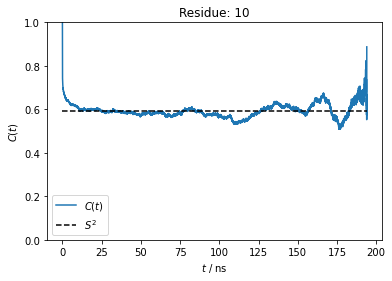

In [50]:
resi=10
i=np.argmax(resids==resi) # Finds where this is true  
data=proj['MD']['raw']['.+aligned']  #Finds the unprocessed MD data

ax=plt.subplots()[1]
ax.plot(t,data.R[i])
ax.plot(t[[0,-1]],np.ones(2)*data.S2[i],color='black',linestyle='--')
ax.set_xlabel(r'$t$ / ns')
ax.set_ylabel(r'$C(t)$')
ax.set_title(f'Residue: {resi}')
ax.legend((r'$C(t)$',r'$S^2$'))
_=ax.set_ylim([0,1])

Plot the spectral density for a few residues (code below)

In [51]:
resi=2
i=np.argmax(resids==resi) # Finds where this is true  
Ct=data.R[i]-data.S2[i]
Ct[0]/=2  #Single-sided FT, need to cut first point in half
dt=(t[1]-t[0])*1e-9
J=2*np.fft.fftshift(np.fft.fft(Ct[:len(Ct)//2],n=len(Ct))).real*dt

f=1/(2*dt)*np.linspace(-1,1,len(t))/1e6
f-=(f[1]-f[0])/2

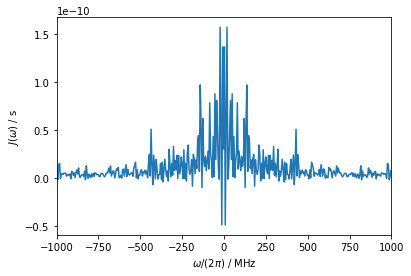

In [52]:
ax=plt.subplots()[1]
ax.plot(f,J)
ax.set_xlabel(r'$\omega/(2\pi)$ / MHz')
ax.set_ylabel(r'$J(\omega)$ / s')
_=ax.set_xlim([-1000,1000])

### Exercise 1.1
Why do we recommend fitting the correlation function rather than taking the correlation function directly?

## Part 2: Multi-exponential fitting (model-free-like analysis)
In the hidden cell, we define a class below to extract model free parameters from MD-derived correlation functions, that also includes a variety of plotting functions.

In [117]:
class MF():
    def __init__(self,n:int=5,aligned:bool=True,Type='MD',proj=proj):
        self._Type=Type
        self.proj=proj
        self._n=None
        self.aligned=aligned
        self._z=None
        self._A=None
        self.fit=None
        self.chi2=None
        self.n=n
    
    @property
    def Type(self):
        return self._Type
    
    @Type.setter
    def Type(self):
        assert 0,'Type (MD/NMR) cannot be changed after initialization'
        
    def _title(self,pre):
        if pre=='n':
            pre='n12' if self.Type=='MD' else 'n6'
            
        if self.Type=='MD':
            return f'{pre}:MD:ubi'+('_aligned' if self._aligned else '$')
        return f'{pre}:NMR:ubi'+('_soln' if self._aligned else '$')
    
    def _mdtitle(self,pre):
        return f'{pre}:MD:ubi'+('_aligned' if self._aligned else '$')
                
    @property
    def n(self):
        return self._n
    
    @n.setter
    def n(self,n):
        if hasattr(self,'_n') and n==self._n:
            return
        self._n=n
        if len(proj[self._title(f'p{n}')])==0:
            self.proj[self._title('n')].detect.r_auto(n=n)
            self.proj[self._title('n')].fit()
        data=proj[self._title(f'p{n}')][0]

        fixz=[-14,*[None for _ in range(self.nz-1)]] if n%2 else None
            
        z,A,chi2,fit=model_free(data,self.nz,fixz=fixz,include=[True for _ in range(n)])
        self.z=z
        self.A=A
        self.fit=fit
        self.chi2=chi2
        
    @property
    def nz(self):
        return np.ceil(self.n/2).astype(int)
        
    @property
    def aligned(self):
        return self._aligned
    
    @aligned.setter
    def aligned(self,aligned):
        if hasattr(self,'_aligned') and self._aligned==aligned:
            return
        
        self._aligned=aligned
        
        nd=12 if self.Type=='MD' else 6
        if len(proj[self._title('n')])==0:
            proj[self._title('r')].detect.r_no_opt(nd)
#             if self.Type!='MD':proj[self._title('r')][0].detect.R2ex()
            proj[self._title('r')].fit()
#             proj[self._title('n')].del_exp(index=-1)
        
        if self._n is not None:
            n=self.n    #Force a re-calculation
            self._n=0  
            self.n=n
        
    @property
    def tc(self):
        return 10**self.z
    
    @property
    def S2_fit(self):
        return 1-self.A.sum(0)
    
    @property
    def S2(self):
        return self.proj[self._title('r')].S2
    
    @property
    def resids(self):
        return self.proj[self._title('r')].label
    
    @property
    def t(self):
        return self.proj['MD']['raw']['ubi_aligned'].info['t'].astype(float)
    
    def plot_pars(self,ax:list=None):
        if ax is None:
            fig,ax=plt.subplots(self.nz,2,sharex=True)
            if self.nz<=1:ax=[ax]
        for k,ax0 in enumerate(ax):
            i=self.A[k]>1e-3
            ax0[0].scatter(self.resids[i],self.A[k][i],s=5,color='red')
            ax0[0].set_ylabel('A')
            ax0[0].set_ylim([-.01,ax0[0].get_ylim()[1]])
            ax0[1].scatter(self.resids[i],self.z[k][i],s=5,color='red')
            ax0[1].set_ylabel(r'$\log_{10}(\tau_c$ / s$)$')
            if ax0[0].is_last_row():
                for a in ax0:a.set_xlabel('Residue')
        
        fig.set_size_inches([8,3*self.nz])
        fig.tight_layout()
        return ax
    
    @property
    def Ct_fit(self):
        ct=np.ones([len(self.t),len(self.resids)])*self.S2_fit
        for tc0,A0 in zip(self.tc,self.A):
            ct+=np.exp(-np.kron(np.atleast_2d(self.t*1e-9).T,np.atleast_2d(1/tc0)))*A0
        return ct.T
    
    @property
    def Ct(self):
        return self.proj[self._mdtitle('r')].R
    
    def plot_ct(self,resi:int,semilog=False,show_fit=None,ax=None):
        if ax is None:
            ax=plt.subplots()[1]
        i=self.resids==resi
        assert np.any(i),'No data for selected residue'
        i=np.argmax(i)
        
        if show_fit is None:show_fit=self.Type=='MD'
        
        plot=ax.semilogx if semilog else ax.plot
        if show_fit:
            i0=np.argmax(self.proj['MD']['raw'][0].label==resi)
            plot(self.t,self.Ct[i0],color='red')
            plot(self.t,self.Ct_fit[i],color='black',linestyle='--')
            ax.legend(('MD','fit'))
        else:
            plot(self.t,self.Ct_fit[i],color='red')
        ax.set_xlabel(r'$t$ / ns')
        ax.set_ylabel(r'$C(t)$')
        ax.set_title(f'Residue: {resi}')

        return ax
    
    @property
    def data(self):
        return self.proj[self._title(f'p{self.n}')][0]
    
    @property
    def nmr_data(self):
        return self.proj['r:NMR:ubi'+('_soln' if self.aligned else '')][0]
        
    @property
    def nmr_sens(self):
        return self.nmr_data.sens
    
    @property
    def relax_rates(self):
        R=np.ones([len(self.resids),self.nmr_sens.rhoz.shape[0]])*self.nmr_sens.R0
        for z0,A0 in zip(self.z,self.A):
            R+=(A0*linear_ex(self.nmr_sens.z,self.nmr_sens.rhoz,z0)).T
        return R
    
    @property
    def det_relax_rates(self):
        assert self.Type=='MD','Relaxation rates from detectors only from MD'
        data=self.proj[self._title('n')]
        data.detect.r_target(target=self.nmr_sens.rhoz)
        self.proj.remove_data(-1)
        return data.R
    
    def plot_rates(self,det=False,ax=None):
        if ax is None:
            fig,ax=plt.subplots(3,3)
            ax=ax.flatten()
        else:
            fig=ax[0].figure
        rates=self.det_relax_rates if det else self.relax_rates
        for k,a in enumerate(ax):
            a.bar(self.nmr_data.label,self.nmr_data.R[:,k],color=plt.get_cmap('tab10')(k),zorder=0)
            a.scatter(self.resids,self.relax_rates[:,k],s=10,color='black',zorder=10)
            Type=self.nmr_data.info[k]["Type"]
            if len(Type)==2:Type=rf'${Type[0]}_{Type[1]}$'
            a.set_title(Type+f' @ {self.nmr_data.info[k]["v0"]} MHz')
        fig.set_size_inches([11,9])
        fig.tight_layout()
        return ax
    
    def plot_fit(self):
        self.proj.close_fig('all')
        self.data.plot(style='bar')
        self.fit.plot(style='s')
        return self.proj.plot_obj

### Investigate the quality of multi-exponential fitting of the correlation function

The value of `n` below determines how many parameters are used to fit the correlation times. If an even value is used, then we have $n/2$ pairs of amplitudes and correlation times to fit the correlation function. If an odd value is used, then we have $(n-1)/2$ pairs of amplitudes and correlation times, plus a single "fast" motion, which will have an arbitrarily short. correlation time (it will account for the decay between the first two time points of the correlation function)

### Exercise 2.1
Adjust `n` below until you're satisfied with the fit of the correlation functions. A sample of correlation functions is plotted to see the fit quality (if you get the plotted correlation functions to fit, the other correlation functions should be ok, but you may also adjust which correlation functions to see, for example, by changing `mf.resids[10::4]` to `mf.resids[1::4]`, which adjusts the first correlation function to show). 

What value of `n` do you get?

In [119]:
mf=MF(n=3)

/Users/albertsmith/Documents/GitHub.nosync/pyDR/Fitting/fit.py:400: RuntimeWarning: invalid value encountered in reciprocal
  pinv=((m**2).sum(1)**(-1))*m.T


Iterations |██████████████████████████████| 100%  of 4 steps
Completed
Data already in project (index=6)


In [ ]:
fig,ax=plt.subplots(4,4,sharex=True,sharey=True,figsize=[12,10])
ax=ax.flatten()
for a,resi in zip(ax,mf.resids[9::4]):
    mf.plot_ct(resi=resi,semilog=True,ax=a)
    if not(a.is_first_col()):
        a.set_ylabel('')
    if not(a.is_last_row()):
        a.set_xlabel('')
fig.tight_layout()

### Exercise 2.2
Repeat exercise 2.1 but without alignment. What value of $n$ do you get? Why is it different?

In [61]:
mfNA=MF(n=3,aligned=False)

/Users/albertsmith/Documents/GitHub.nosync/pyDR/Fitting/fit.py:400: RuntimeWarning: invalid value encountered in reciprocal
  pinv=((m**2).sum(1)**(-1))*m.T


Iterations |██████████████████████████████| 100%  of 4 steps
Completed
Data already in project (index=11)


In [ ]:
fig,ax=plt.subplots(4,4,sharex=True,sharey=True,figsize=[12,10])
ax=ax.flatten()
for a,resi in zip(ax,mfNA.resids[11::4]):
    mfNA.plot_ct(resi=resi,semilog=True,ax=a)
    if not(a.is_first_col()):
        a.set_ylabel('')
    if not(a.is_last_row()):
        a.set_xlabel('')
fig.tight_layout()

### Exercise 2.3
Plot the model free parameters below. Are the fit parameters reliable? What does the slowest correlation time and corresponding amplitude tell us. The fastest correlation time was fixed to 10 femtoseconds. What does this correlation time and amplitude tell us?

In [ ]:
_=mf.plot_pars()

## Part 3: Calculating relaxation rate constants
We can use the formulas at the beginning of this document to calculate relaxation constants for various experiments. Note that to reproduce an experiment, we need to account for the total motion, which includes tumbling (that we have factored out). It will be useful to note that tumbling occurs for ubiquitin with a correlation time of 4.84 ns. The total correlation function is given by

$$
\begin{eqnarray}
C(t)&=&C_{tumbl.}(t)\cdot C_{int.} \\
&=&\frac15\exp(-t/\tau_M)\left(S^2+\sum\limits_i{A_i\exp(-t/\tau_i)}\right) \\
&=&\frac15\left(S^2\exp(-t/\tau_M)+\sum\limits_i{A_i}\exp(-t/\tau^i_{eff})\right)
\end{eqnarray}
$$

With definitions

$$
\begin{eqnarray}
S^2&=&1-\sum_i{A_i} \\
\tau_{eff}^i&=&\frac{\tau_i\tau_M}{\tau_i+\tau_M}
\end{eqnarray}
$$

Then, to obtain the relaxation rate constants, we have a few steps:

1. Calculate the order parameter

2. Calculate the effective correlation times

3. For each effective correlation time and the overall tumbling
    
    * Calculate the spectral density at the required frequencies
    * Add all terms
    * Scale by the interaction strengths
    
    
4. Add all terms together

### Exercise 3.1
Write a function for the effective correlation time ($\tau_{eff}^i)$ given the internal correlation time ($\tau_i$) and the correlation time of tumbling ($\tau_M$). This has been started for you: just fill in the line `return ...`, replacing `...` with the correct formula. Try the formula, and see how it behaves if the internal motion is a lot faster, a lot slower, or similar to the correlation time of the tumbling.

In [18]:
def tcEff(ti,tM):
    return ...

In [ ]:
# Test tcEFF here

### Exercise 3.2
Write a function for the spectral density from a single correlation time with inputs of amplitude (`A`), correlation time (`tc`), and frequency (`v`, give in MHz). Plot the spectral density as a function of correlation time (on a log scale) for a fixed field, and as a function of frequency (for a fixed correlation time). You can set `A=1` for these calculations. Which of these functions has a well-defined maximum, and where is it? 

Note, in Python, to obtain a power, use the `**` symbol (e.g. `2**3=8`).

In [21]:
def J(A,tc,v):
    omega=2*np.pi*1e6*v   #Convert MHz to rad/s
    return ...

In [ ]:
fig,ax=plt.subplots(1,2,figsize=[9,4])
tc=np.logspace(-12,-6,200)
ax[0].semilogx(tc,J(1,tc,100))
ax[0].set_xlabel(r'$\tau_c$ / s')
ax[0].set_ylabel(r'$J(\omega,\tau_c)$')
ax[0].set_title(r'$J(\omega,\tau_c)$ vs. $\tau_c$')
v0=np.logspace(-1,3,200)
ax[1].semilogx(v0,J(1,1e-8,v0))
ax[1].set_xlabel(r'$\omega_{2\pi}$ / MHz')
ax[1].set_title(r'$J(\omega,\tau_c)$ vs. $\omega$')
ax[1].set_ylabel(r'$J(\omega,\tau_c)$ / s')
fig.tight_layout()

### Exercise 3.3
Below is a function for calculating $R_1$ from a list of correlation times (`tc`) and amplitudes (`A`), in addition to the tumbling correlation time (`tM`), and the magnetic field in MHz ($^1$H frequency). Following this approach, write a function for the heteronuclear NOE and $R_2$ (these have been started for you). Note the $^{15}N$ Larmor frequency is -1/9.862 times the $^1$H Larmor frequency.

In [67]:
print(f'Ratio of Larmor frequencies: {pyDR.tools.NucInfo("1H")/pyDR.tools.NucInfo("15N"):.3f}')

Ratio of Larmor frequencies: -9.862


In [68]:
# The required interaction anisotropy parameters are stored in pyDR
delta=proj[0].sens.info[0]['dXY']
DelSigma=proj[0].sens.info[0]['CSA']*3/2

def R1(tM,tc,A,v0H):  #v0H in MHz
    v0N=-v0H/9.862
    S2=1-A.sum(0) # Could use multi-dimensional inputs
    tceff=tcEff(tc,tM) #Effective correlation times
    
    # 1) Relaxation due to tumbling + dipole coupling
    R1=(2*np.pi*delta/4)**2*(J(S2,tM,v0H-v0N)+3*J(S2,tM,v0N)+6*J(S2,tM,v0H+v0N))
    # 2) Relaxation due to tumbling + CSA
    R1+=1/3*(2*np.pi*v0N*DelSigma)**2*J(S2,tM,v0N)
    
    for tc0,A0 in zip(tceff,A):  #Now loop over internal motions with effective tc
        # 3) Internal motion + dipole
        R1+=(2*np.pi*delta/4)**2*(J(A0,tc0,v0H-v0N)+3*J(A0,tc0,v0N)+6*J(A0,tc0,v0H+v0N))
        # 4) Internal motion + CSA
        R1+=1/3*(2*np.pi*v0N*DelSigma)**2*J(A0,tc0,v0N)
        
    return R1/5 #Don't forget the 1/5!

In [69]:
def R2(tM,tc,A,v0H):
    v0N=-v0H/9.862
    S2=1-A.sum(0) # Could use multi-dimensional inputs
    tceff=tcEff(tc,tM) #Effective correlation times

    # 0) R1 contributions
    R2=R1(tM,tc,A,v0H)
    # 1) Relaxation due to tumbling + dipole coupling
    R2+=...
    # 2) Relaxation due to tumbling + CSA
    R2+=...
    
    for tc0,A0 in zip(tceff,A):  #Now loop over internal motions with effective tc
        # 3) Internal motion + dipole
        R2+=...
        # 4) Internal motion + CSA
        R2+=...
        
    return R2/5 #Don't forget the 1/5!

def NOE(tM,tc,A,v0H):
    v0N=-v0H/9.862
    S2=1-A.sum(0) # Could use multi-dimensional inputs
    tceff=tcEff(tc,tM) #Effective correlation times

    # 1) Relaxation due to tumbling + dipole coupling
    NOE+=...
    
    for tc0,A0 in zip(tceff,A):  #Now loop over internal motions with effective tc
        # 2) Internal motion + dipole
        NOE+=...
        
    return ... #Don't forget the 1/5!

### Plot your results
Plot results below for a few fields

In [ ]:
# Correlation time for ubiquitin already stored with NMR data
tM=proj['NMR']['raw'][0].info['tM'][0]   #4.5 ns

cmap=plt.get_cmap('tab10')

fig,ax=plt.subplots(3,3,figsize=[12,9],sharex=True)

for k,(ax0,v0H) in enumerate(zip(ax,[600,800,950])):
    ax0[0].bar(mf.resids,R2(tM,mf.tc,mf.A,v0H),color=cmap(k))
    ax0[1].bar(mf.resids,R1(tM,mf.tc,mf.A,v0H),color=cmap(k))
    ax0[2].bar(mf.resids,NOE(tM,mf.tc,mf.A,v0H),color=cmap(k))
    for a,exp in zip(ax0,[r'$R_2$',r'$R_1$','NOE']):
        a.set_ylim([0,a.get_ylim()[1]])
        a.set_ylabel(exp+r' / s$^{-1}$')
    ax0[1].set_title(f'{v0H} MHz')
for a in ax[-1]:a.set_xlabel('Residue')
       
for ax0,yl in zip(ax.T,[10,2.5,.2]):
    for a in ax0:a.set_ylim([0,yl])
    
fig.tight_layout()

### Exercise 3.4
How does each experiment change as a function of field, and what drives this behavior?


## Part 4: Comparing to experiment
Above, we downloaded experimental relaxation rate constants from Charlier et al. Note that the correlation time of tumbling we used previously (4.84 ns) is extracted from this data set. Now we will compare these to our calculated results. Plotting is set up for you below.

C. Charlier, S.N. Khan, T. Marquardsen, P. Pelupessy, V. Reiss, D. Sakellariou, G. Bodenhausen, F. Engelke, F. Ferrage. [*J. Am. Chem. Soc.*](https://doi.org/10.1021/ja409820g), **2013**, 135, 18665

In [ ]:
# Correlation time for ubiquitin already stored with NMR data
tM=proj['NMR']['raw'][0].info['tM'][0]   #4.5 ns

fig,ax=plt.subplots(3,3,figsize=[12,9],sharex=True)

for k,(ax0,v0H) in enumerate(zip(ax,[600,800,950])):
    i=np.argmax(np.logical_and(mf.nmr_data.info['v0']==v0H,mf.nmr_data.info['Type']=='R2'))
    ax0[0].bar(mf.nmr_data.label,mf.nmr_data.R[:,i],color=cmap(k))
    ax0[0].scatter(mf.resids,R2(tM,mf.tc,mf.A,v0H),s=5,color='black',zorder=10)
    i=np.argmax(np.logical_and(mf.nmr_data.info['v0']==v0H,mf.nmr_data.info['Type']=='R1'))
    ax0[1].bar(mf.nmr_data.label,mf.nmr_data.R[:,i],color=cmap(k))
    ax0[1].scatter(mf.resids,R1(tM,mf.tc,mf.A,v0H),s=5,color='black',zorder=10)
    i=np.argmax(np.logical_and(mf.nmr_data.info['v0']==v0H,mf.nmr_data.info['Type']=='NOE'))
    ax0[2].bar(mf.nmr_data.label,mf.nmr_data.R[:,i],color=cmap(k))
    ax0[2].scatter(mf.resids,NOE(tM,mf.tc,mf.A,v0H),s=5,color='black',zorder=10)
    for a,exp in zip(ax0,[r'$R_2$',r'$R_1$','NOE']):
        a.set_ylim([0,a.get_ylim()[1]])
        a.set_ylabel(exp+r' / s$^{-1}$')
    ax0[1].set_title(f'{v0H} MHz')
for a in ax[-1]:a.set_xlabel('Residue')
       
for ax0,yl in zip(ax.T,[10,2.5,.2]):
    for a in ax0:a.set_ylim([0,yl])
    
fig.tight_layout()

### Exercise 4.1
How do the results compare to experiment? What does this tell you about the quality of the MD simulation?

### Exercise 4.2

The object below (`mf_nmr`) allows model-free fitting of the *NMR* data. How many parameters (`n`) are sufficient to fit the data? Evaluate by eye via the `plot_rates` function and use the calculated value for $\chi^2$

Iterations |██████████████████████████████| 100%  of 1 steps
Completed
Data already in project (index=22)
207915.1


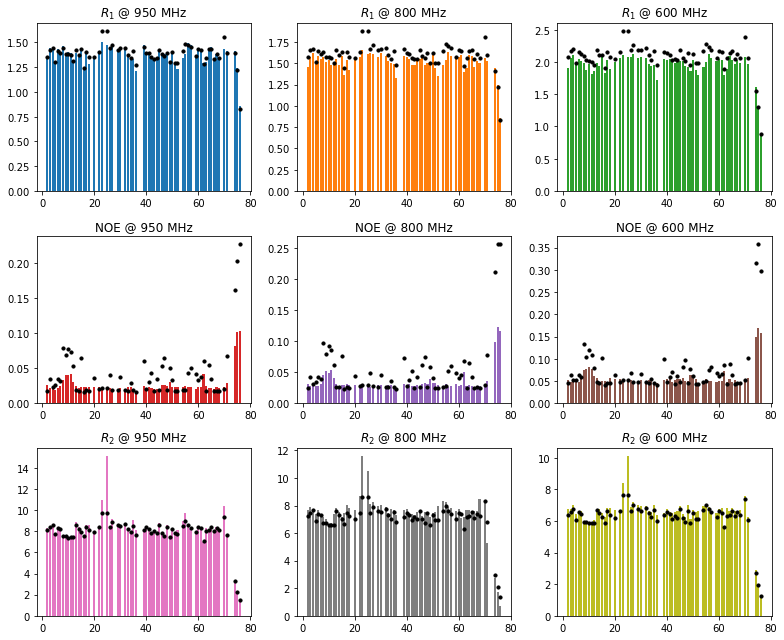

In [100]:
mf_nmr=MF(Type='NMR',n=2)

chi2=((mf_nmr.relax_rates-mf_nmr.nmr_data.R)**2/mf_nmr.nmr_data.Rstd**2).sum()
print(f'chi^2: {chi2:.1f}')

_=mf_nmr.plot_rates()

### Exercise 4.3
The following cell plots the model-free parameters used to fit the experimental data. Comment on the degree of scatter from one residue to the next (how noisy does the data look to you) compared to the relaxation rate constants themselves.

In [ ]:
_=mf_nmr.plot_pars()

## Part 5. Detector analysis of MD and NMR
The noisiness of the model-free analysis above led us to develop a method called the *detector analysis* to treat relaxation data. We believe the key problem with model-free analysis is that protein motion is not well-described by a few correlation times, but is much more consistent with a broad distribution of correlation times. We've explored this topic throughout a number of publications and how to go about treating the data in such cases ([why model-free fails](https://doi.org/10.1002/anie.201707316), [further discussion](https://doi.org/10.3389/fmolb.2021.727553), [solution-state approach](https://doi.org/10.1063/1.5111081)).

The basic idea is that rather than writing a sum of correlation times, we write a distribution:

$$
\begin{eqnarray}
C_{int.}(t)&=&S^2+(1-S^2)\sum\limits_i{A_i\exp(-t/\tau_i)} \\
&=&S^2+(1-S^2)\int\limits_{-\infty}^\infty{\theta(z)\exp(-t/(10^z\cdot s)dt}
\end{eqnarray}
$$

Technically, the two formulas are interchangeable, but the latter emphasizes the potential for a near-continuum of correlation times, which would require a summation of very many terms to represent with the former formula. 

In any case, we cannot fully parameterize such a model, so instead we capture motion within well-defined correlation time "windows", defined by the functions $\rho_n(z)=\rho_n(\tau_c)$, where $z=\log_{10}(\tau_c)$.

$$
\begin{eqnarray}
\rho_n^{(\theta,S)}&=&(1-S^2)\sum\limits_i{A_i\rho_n(\tau_i)} \\
&=&(1-S^2)\int\limits_{-\infty}^\infty{\theta(z)\rho_n(z)dz}
\end{eqnarray}
$$

Then, we parameterize our data with a number of these parameters, $\rho_n^{(\theta,S)}$, which give the amplitude of motion for a well-defined range of correlation times. Analysis is performed below with the pyDIFRATE software (a detailed tutorial on pyDIFRATE can be found [here](https://alsinmr.github.io/pyDR).

### Detector analysis
We start from scratch so you can see that this process is relatively straightforward (of course, the software itself is doing a lot, but for the user it is not too difficult). Data will be stored in a *project* (`proj`)

#### Step 1: Process NMR
The key steps are
* Make a project, download the data
* Adjust the correlation time of tumbling (not always necessary)
* Set up detectors (here, we use 5 detectors)
* fit the data
* plot the data

In [78]:
# Create a project for data storate
proj=pyDR.Project()
# Download the data
proj.append_data('https://raw.githubusercontent.com/alsinmr/pyDR_tutorial/main/data/ubi_soln.txt')
# Adjust the correlation time of tumbling
proj[0].sens.info['tM']=4.5e-9
# Use 5 detectors for analysis
proj['NMR'].detect.r_auto(5)
# Fit the NMR data
proj['NMR'].fit()
# Plot the result
proj['proc']['NMR'].plot(style='bars')
# Show correlation times, Adjust the figure size
proj.plot_obj.show_tc()
proj.fig.set_size_inches([6,8])

#### Step 2: Process MD
The key steps are:
* Load the MD trajectory (aligned) as a MolSelect object
* Select the desired bonds to analyze
* Load correlation functions into a data object (stored in `proj`)
* Set up detectors (here use 7, but match the first five to the NMR sensitivities with `r_target`)
* Fit the data
* Optimize the fit (optional)
* Plot the results

In [ ]:
# Create MolSelect object
sel=pyDR.MolSelect(topo='ubi.pdb',traj_files='ubi_aligned.xtc',project=proj)
# Select the desired bonds
sel.select_bond('15N')
# Load correlation functions 
#(because proj was assigned to sel, result goes into proj automatically)
pyDR.md2data(sel)
# Get NMR sensitivity as target for MD sensitivity
target=proj['NMR']['proc'].sens.rhoz
# Optimize detectors for MD
proj['MD'].detect.r_target(target=target,n=7)
# Fit and then optimize the fit
proj['MD'].fit().opt2dist(rhoz=target)

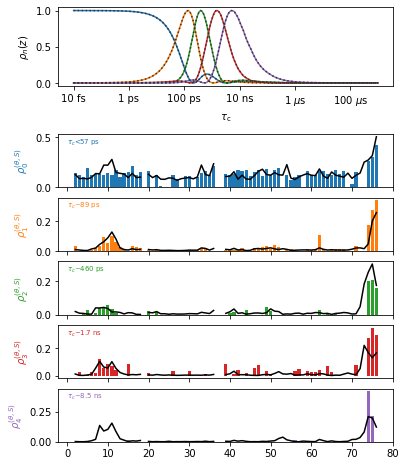

In [80]:
#Plot the results (bars are experiment, lines are simulation)
proj.close_fig('all')      #in pyDR, projects manage the figures
proj['proc']['NMR'].plot(style='bar')
proj['opt_fit']['MD'].plot()
proj.plot_obj.show_tc()
proj.plot_obj.fig.set_size_inches([6,8])

### Exercise 5.1
The bar plots above represent the amplitude of motion for experimental data and the black line plots represent MD data. Around what correlation times do we have good agreement, poor agreement, and ok agreement. What does this tell you about the NMR and MD data quality?


### Exercise 5.2
Which do you consider more stable, the detector parameters ($\rho_n^{(\theta,S)}$) or the model-free parameters? Which parameters give you a more physical understanding of the motion?